# What are autoencoders?

![](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

### **"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.**



* 1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

* 2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

* 3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

* To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent. It's simple! And you don't even need to understand any of these words to start using autoencoders in practice.

# Are they good at data compression?
* Usually, not really. In picture compression for instance, it is pretty difficult to train an autoencoder that does a better job than a basic algorithm like JPEG, and typically the only way it can be achieved is by restricting yourself to a very specific type of picture (e.g. one for which JPEG does not do a good job). The fact that autoencoders are data-specific makes them generally impractical for real-world data compression problems: you can only use them on data that is similar to what they were trained on, and making them more general thus requires lots of training data. But future advances might change this, who knows.

# What are autoencoders good for?
* They are rarely used in practical applications. In 2012 they briefly found an application in greedy layer-wise pretraining for deep convolutional neural networks [1], but this quickly fell out of fashion as we started realizing that better random weight initialization schemes were sufficient for training deep networks from scratch. In 2014, batch normalization [2] started allowing for even deeper networks, and from late 2015 we could train arbitrarily deep networks from scratch using residual learning [3].

* Today two interesting practical applications of autoencoders are data denoising (which we feature later in this post), and dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

* For 2D visualization specifically, t-SNE (pronounced "tee-snee") is probably the best algorithm around, but it typically requires relatively low-dimensional data. So a good strategy for visualizing similarity relationships in high-dimensional data is to start by using an autoencoder to compress your data into a low-dimensional space (e.g. 32-dimensional), then use t-SNE for mapping the compressed data to a 2D plane. Note that a nice parametric implementation of t-SNE in Keras was developed by Kyle McDonald and is available on Github. Otherwise scikit-learn also has a simple and practical implementation.

# So what's the big deal with autoencoders?
* Their main claim to fame comes from being featured in many introductory machine learning classes available online. As a result, a lot of newcomers to the field absolutely love autoencoders and can't get enough of them. This is the reason why this tutorial exists!

* Otherwise, one reason why they have attracted so much research and attention is because they have long been thought to be a potential avenue for solving the problem of unsupervised learning, i.e. the learning of useful representations without the need for labels. Then again, autoencoders are not a true unsupervised learning technique (which would imply a different learning process altogether), they are a self-supervised technique, a specific instance of supervised learning where the targets are generated from the input data. In order to get self-supervised models to learn interesting features, you have to come up with an interesting synthetic target and loss function, and that's where problems arise: merely learning to reconstruct your input in minute detail might not be the right choice here. At this point there is significant evidence that focusing on the reconstruction of a picture at the pixel level, for instance, is not conductive to learning interesting, abstract features of the kind that label-supervized learning induces (where targets are fairly abstract concepts "invented" by humans such as "dog", "car"...). In fact, one may argue that the best features in this regard are those that are the worst at exact input reconstruction while achieving high performance on the main task that you are interested in (classification, localization, etc).

* In self-supervized learning applied to vision, a potentially fruitful alternative to autoencoder-style input reconstruction is the use of toy tasks such as jigsaw puzzle solving, or detail-context matching (being able to match high-resolution but small patches of pictures with low-resolution versions of the pictures they are extracted from). The following paper investigates jigsaw puzzle solving and makes for a very interesting read: Noroozi and Favaro (2016) Unsupervised Learning of Visual Representations by Solving Jigsaw Puzzles. Such tasks are providing the model with built-in assumptions about the input data which are missing in traditional autoencoders, such as "visual macro-structure matters more than pixel-level details".

![](https://blog.keras.io/img/ae/jigsaw-puzzle.png)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import seaborn as sns
from PIL import Image
import keras
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm
from keras import layers
%matplotlib inline

In [2]:
train_image_path="/kaggle/input/fruit-classification10-class/MY_data/train/"
test_image_path="/kaggle/input/fruit-classification10-class/MY_data/test/"

# Visualize Some Images From Train Data

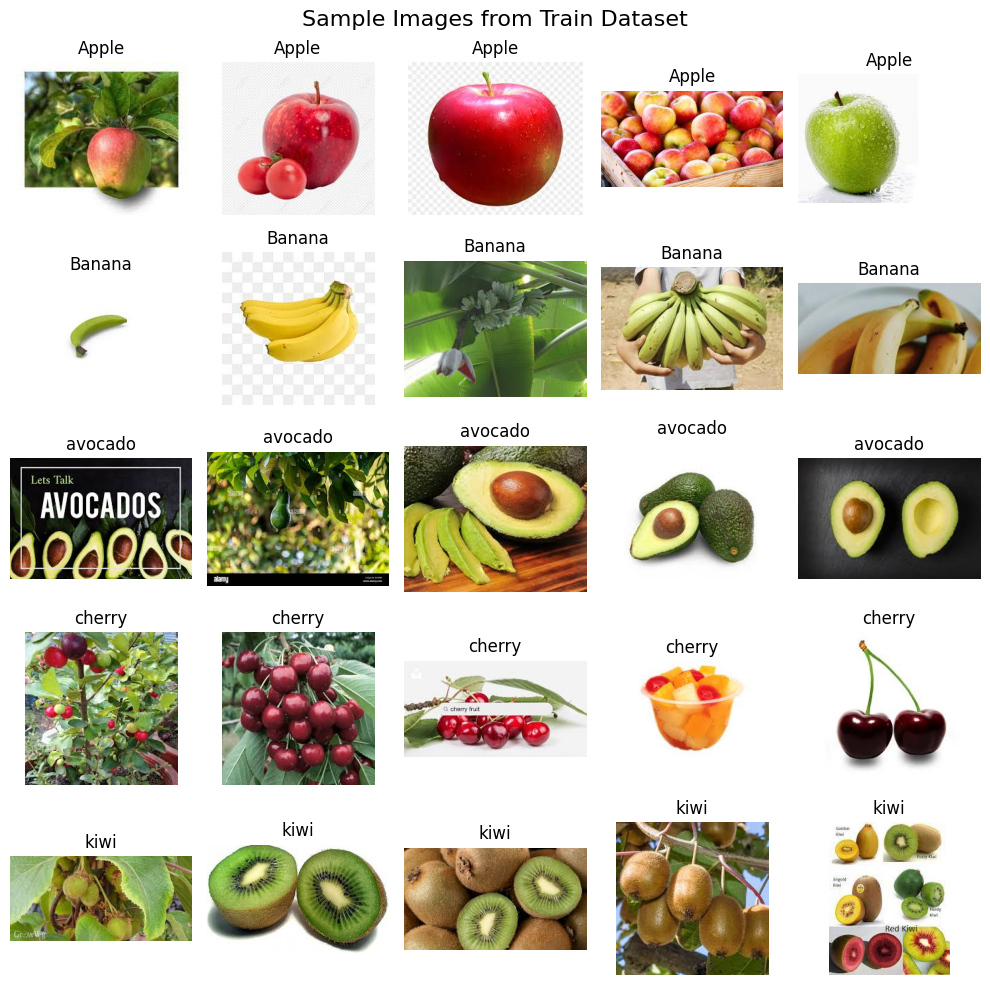

In [3]:
classes = sorted(os.listdir(train_image_path))

image_paths = []
for fruit_class in classes:
    class_path = os.path.join(train_image_path, fruit_class)
    if os.path.isdir(class_path):
        images = [os.path.join(class_path, img) for img in os.listdir(class_path)[:5]]
        image_paths.extend(images)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle("Sample Images from Train Dataset", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(image_paths):
        img = Image.open(image_paths[i])
        ax.imshow(img)
        ax.set_title(image_paths[i].split('/')[-2])
    ax.axis('off')

plt.tight_layout()
plt.show()

# Visualize Some Images From Test Data

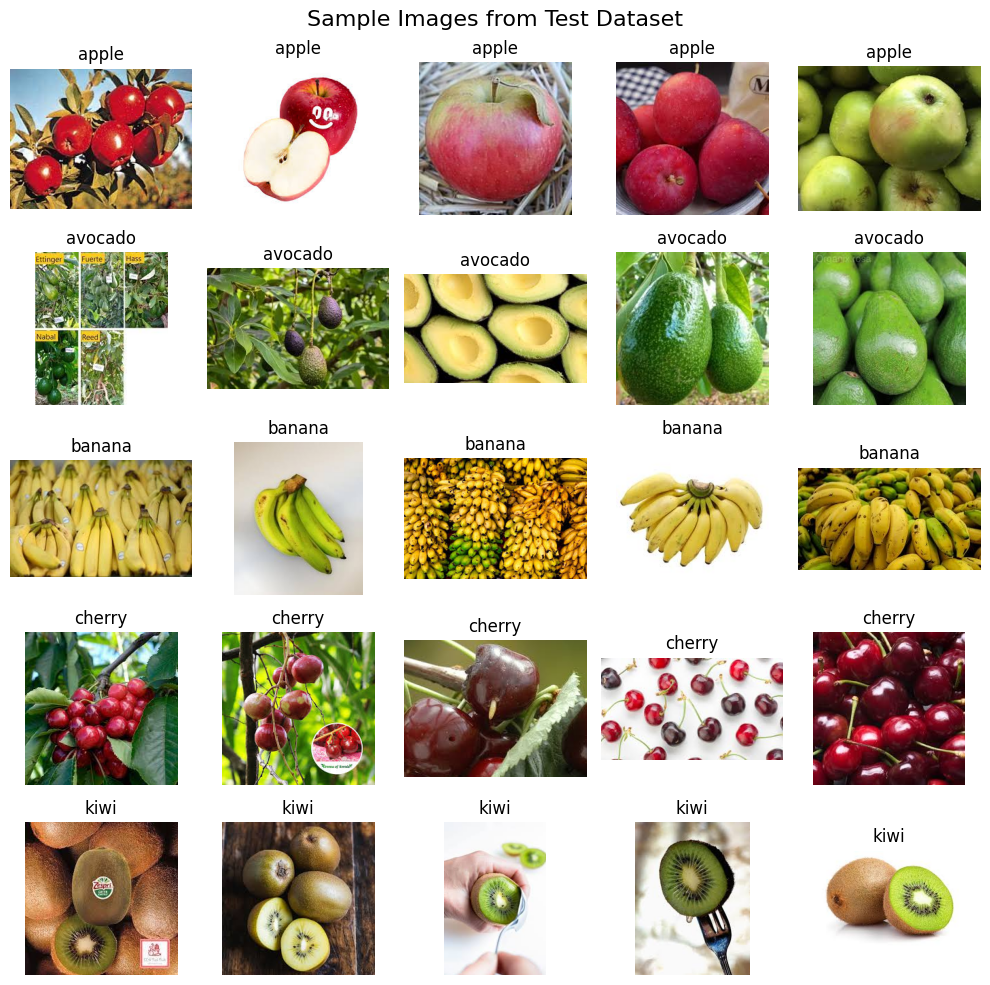

In [4]:
classes = sorted(os.listdir(test_image_path))

image_paths = []
for fruit_class in classes:
    class_path = os.path.join(test_image_path, fruit_class)
    if os.path.isdir(class_path):
        images = [os.path.join(class_path, img) for img in os.listdir(class_path)[:5]]
        image_paths.extend(images)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle("Sample Images from Test Dataset", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(image_paths):
        img = Image.open(image_paths[i])
        ax.imshow(img)
        ax.set_title(image_paths[i].split('/')[-2])
    ax.axis('off')

plt.tight_layout()
plt.show()

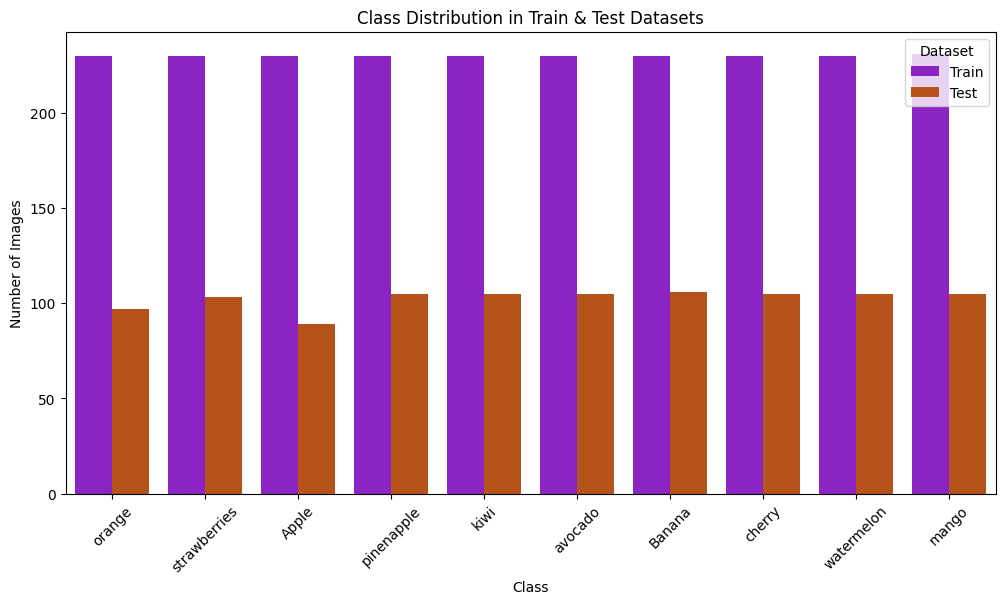

In [5]:
def get_class_distribution(path):
    return {cls: len(os.listdir(os.path.join(path, cls))) for cls in os.listdir(path) if os.path.isdir(os.path.join(path, cls))}

train_distribution = get_class_distribution(train_image_path)
test_distribution = get_class_distribution(test_image_path)

df = pd.DataFrame({"Class": train_distribution.keys(), "Train": train_distribution.values(), "Test": test_distribution.values()})

plt.figure(figsize=(12, 6))
df_melted = df.melt(id_vars="Class", var_name="Dataset", value_name="Count")
sns.barplot(x="Class", y="Count", hue="Dataset", data=df_melted, palette="gnuplot")

plt.xticks(rotation=45)
plt.title("Class Distribution in Train & Test Datasets")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.legend(title="Dataset")
plt.show()

# Let's build the simplest possible autoencoder

In [6]:
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

# Let's also create a separate encoder model:

In [7]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# As well as the decoder model:

In [8]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
decoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 784)                 │          25,872 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,872 (101.06 KB)

 Trainable params: 25,872 (101.06 KB)

 Non-trainable params: 0 (0.00 B)

### Now let's train our autoencoder to reconstruct MNIST digits.

### First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

In [9]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 784)                 │          25,872 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:


def preprocess_images(image_path, target_size=(28, 28)):
    images = []
    labels = []
    
    class_folders = os.listdir(image_path)
    
    for class_name in tqdm(class_folders, desc="Processing images", unit="folder"):
        class_folder = os.path.join(image_path, class_name)
        
        if os.path.isdir(class_folder):
            filenames = os.listdir(class_folder)
            
            for filename in filenames:
                img_path = os.path.join(class_folder, filename)
                
                if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale image
                
                if img is None:
                    print(f"Failed to load image: {img_path}")
                    continue
                
                img = cv2.resize(img, target_size)  # Resize image to 28x28
                img = img.astype("float32") / 255.0  # Normalize the image
                
                img = img.flatten()  # Flatten the image to 784 (28x28)

                images.append(img)
                labels.append(class_name)

    return np.array(images), np.array(labels)

# Now, preprocess the training and testing data
X_train, y_train = preprocess_images(train_image_path)
X_test, y_test = preprocess_images(test_image_path)

# Print shapes of the train and test datasets to confirm
print(f"Train Data Shape: {X_train.shape}")  
print(f"Test Data Shape: {X_test.shape}") 


Processing images:   0%|          | 0/10 [00:00<?, ?folder/s]

Failed to load image: /kaggle/input/fruit-classification10-class/MY_data/train/orange/img_2731.jpeg


Processing images: 100%|██████████| 10/10 [00:01<00:00,  6.41folder/s]

Train Data Shape: (2300, 784)
Test Data Shape: (1025, 784)


In [11]:
history=autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.6851 - val_loss: 0.6339
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6398 - val_loss: 0.6133
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6297 - val_loss: 0.6057
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6171 - val_loss: 0.6014
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6140 - val_loss: 0.5953
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6068 - val_loss: 0.5924
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6064 - val_loss: 0.5879
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6027 - val_loss: 0.5843
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5975 - val_loss: 0.5812
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5973 - val_loss: 0.5785
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5931 - val_loss: 0.5765
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5881 - val_l

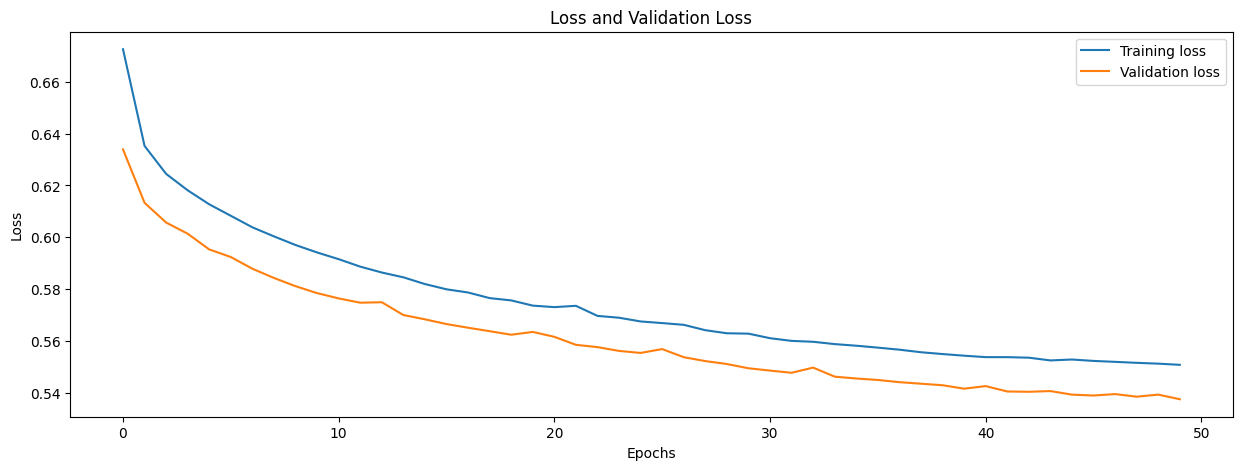

In [12]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


### Here's what we get. The top row is the original Images, and the bottom row is the reconstructed Images. We are losing quite a bit of detail with this basic approach.

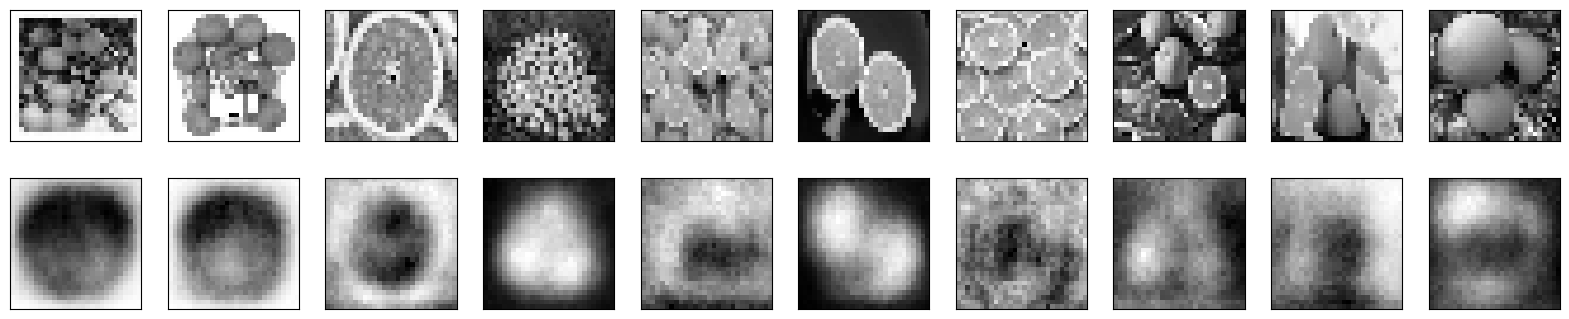

In [14]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
decoded_imgs = autoencoder.predict(X_test)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


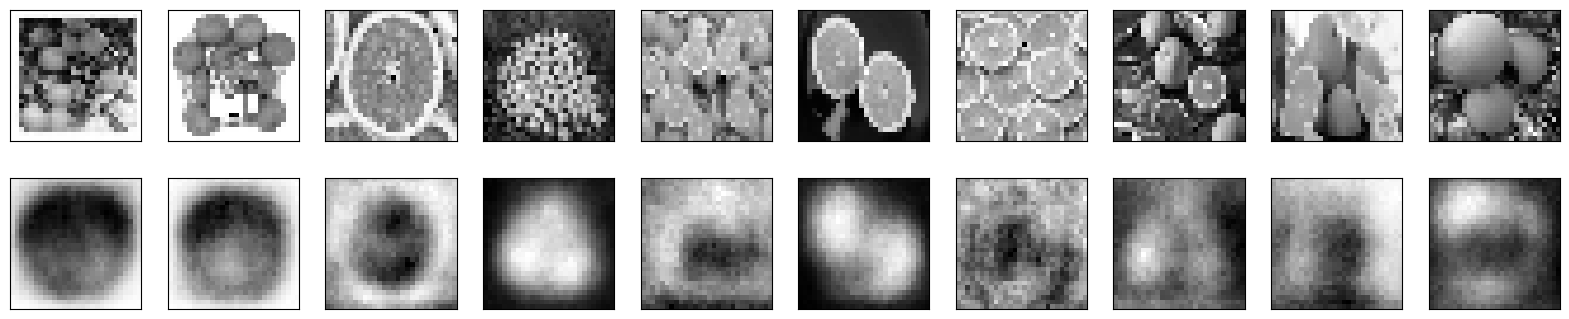

In [16]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Adding a sparsity constraint on the encoded representations
* In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [17]:
from keras import regularizers
encoding_dim = 32

input_img = keras.Input(shape=(784,))
encoded = layers.Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 784)                 │          25,872 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history=autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.7030 - val_loss: 0.6902
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6904 - val_loss: 0.6876
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6882 - val_loss: 0.6853
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6866 - val_loss: 0.6833
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6862 - val_loss: 0.6816
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6836 - val_loss: 0.6800
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6832 - val_loss: 0.6788
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6819 - val_loss: 0.6776
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6818 - val_loss: 0.6766
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6818 - val_loss: 0.6757
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6802 - val_loss: 0.6750
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

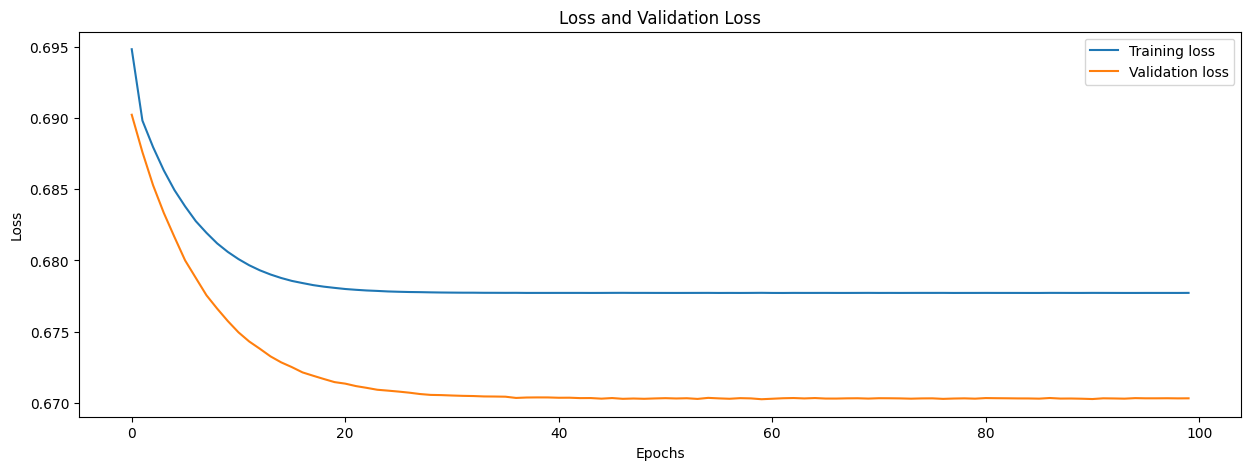

In [19]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


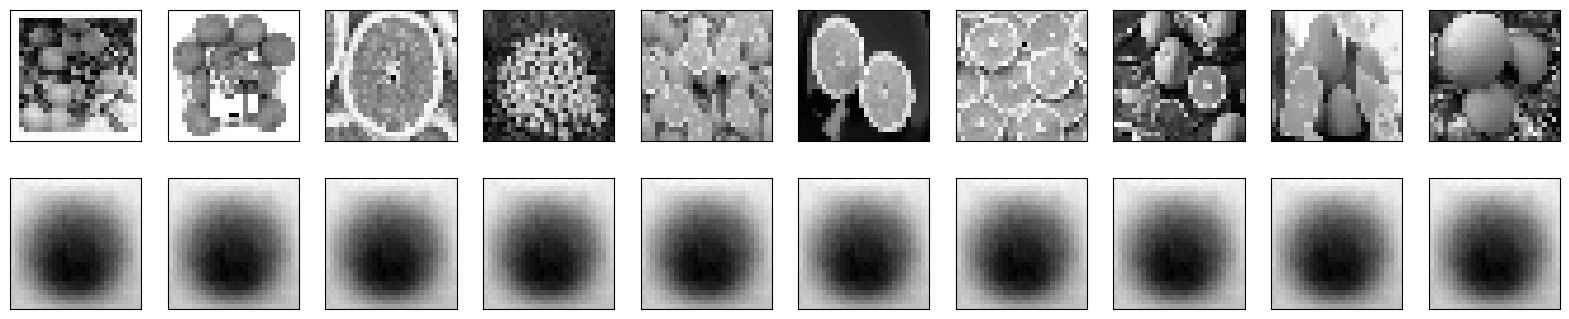

In [20]:
decoded_imgs = autoencoder.predict(X_test)
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Deep autoencoder
* We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [21]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 784)                 │         101,136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,384 (868.69 KB)

 Trainable params: 222,384 (868.69 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.6732 - val_loss: 0.6135
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6308 - val_loss: 0.6028
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6125 - val_loss: 0.5963
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6032 - val_loss: 0.5793
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5887 - val_loss: 0.5747
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5889 - val_loss: 0.5668
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5785 - val_loss: 0.5635
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5791 - val_loss: 0.5613
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5797 - val_loss: 0.5603
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5754 - val_loss: 0.5580
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5698 - val_loss: 0.5547
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

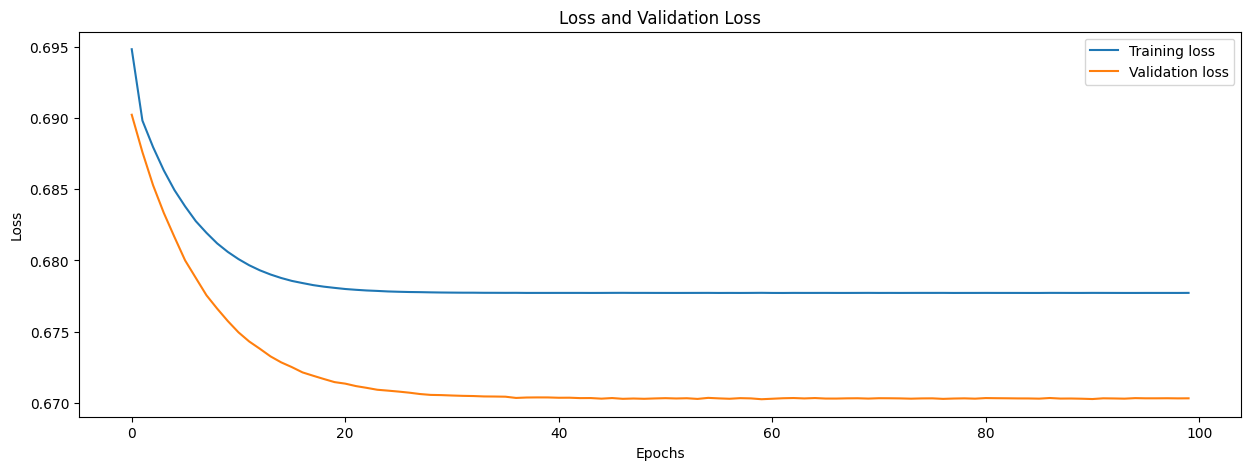

In [23]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


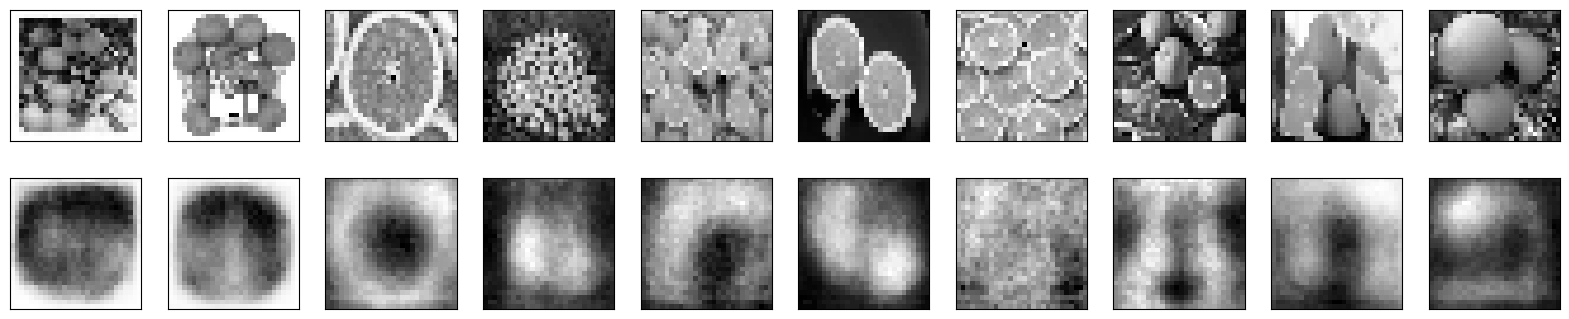

In [24]:
decoded_imgs = autoencoder.predict(X_test)
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional autoencoder
* Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

* Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [25]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
def preprocess_images(image_path, target_size=(28, 28)):
    images = []
    labels = []
    
    class_folders = os.listdir(image_path)
    
    for class_name in tqdm(class_folders, desc="Processing images", unit="folder"):
        class_folder = os.path.join(image_path, class_name)
        
        if os.path.isdir(class_folder):
            filenames = os.listdir(class_folder)
            
            for filename in filenames:
                img_path = os.path.join(class_folder, filename)
                
                if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale image
                
                if img is None:
                    print(f"Failed to load image: {img_path}")
                    continue
                
                img = cv2.resize(img, target_size)  # Resize image to 28x28
                img = img.astype("float32") / 255.0  # Normalize the image

                img=np.expand_dims(img,axis=-1)
                
               

                images.append(img)
                labels.append(class_name)

    return np.array(images), np.array(labels)

# Now, preprocess the training and testing data
X_train, y_train = preprocess_images(train_image_path)
X_test, y_test = preprocess_images(test_image_path)

# Print shapes of the train and test datasets to confirm
print(f"Train Data Shape: {X_train.shape}")  
print(f"Test Data Shape: {X_test.shape}") 

Processing images:  10%|█         | 1/10 [00:00<00:02,  3.81folder/s]

Failed to load image: /kaggle/input/fruit-classification10-class/MY_data/train/orange/img_2731.jpeg


Processing images: 100%|██████████| 10/10 [00:01<00:00,  7.81folder/s]

Train Data Shape: (2300, 28, 28, 1)
Test Data Shape: (1025, 28, 28, 1)


In [27]:
history=autoencoder.fit(X_train,X_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.6839 - val_loss: 0.6355
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6287 - val_loss: 0.5711
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5750 - val_loss: 0.5536
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5674 - val_loss: 0.5454
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5610 - val_loss: 0.5419
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5583 - val_loss: 0.5398
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5528 - val_loss: 0.5374
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5585 - val_loss: 0.5357
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5483 - val_loss: 0.5345
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5495 - val_loss: 0.5329
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5514 - val_loss: 0.5325
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5451 - val_l

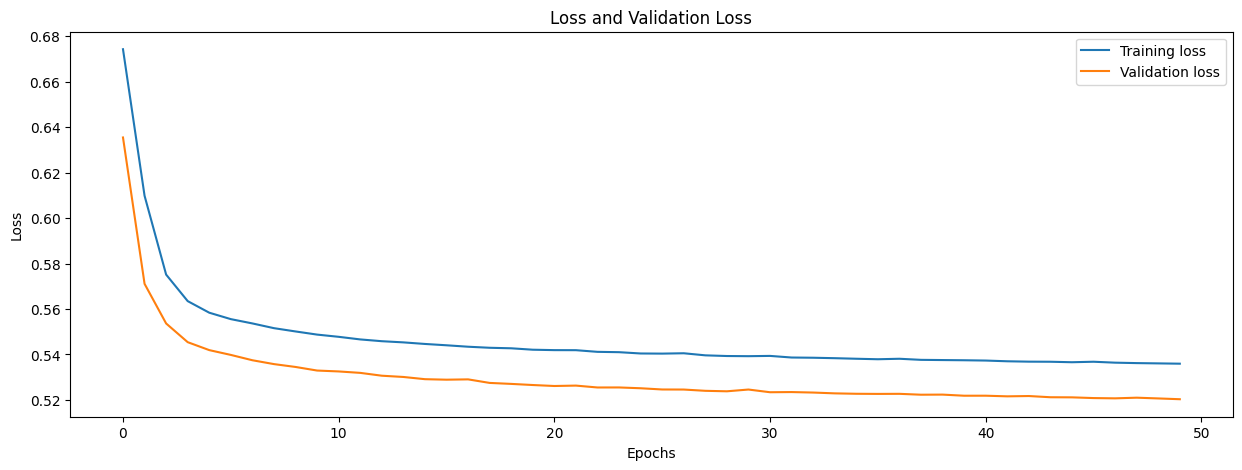

In [28]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step 


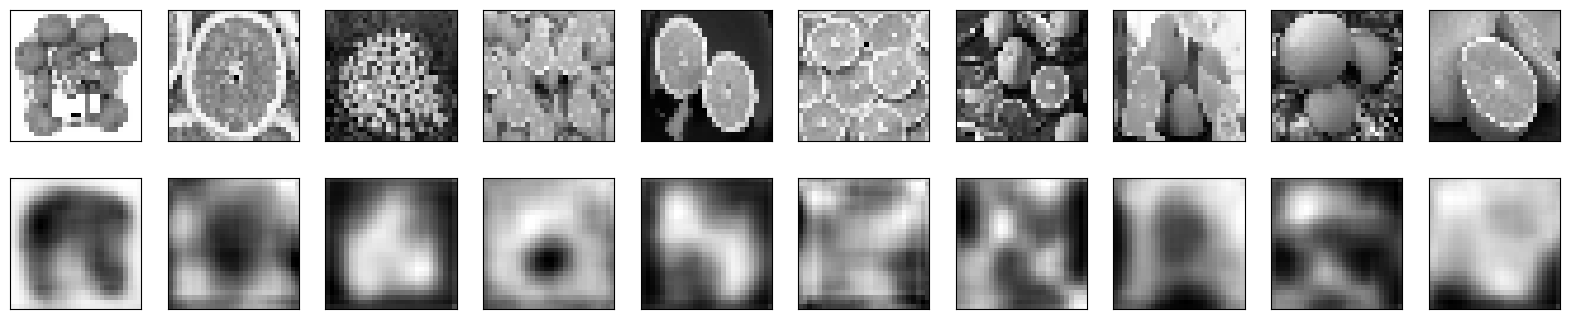

In [29]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### We can also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


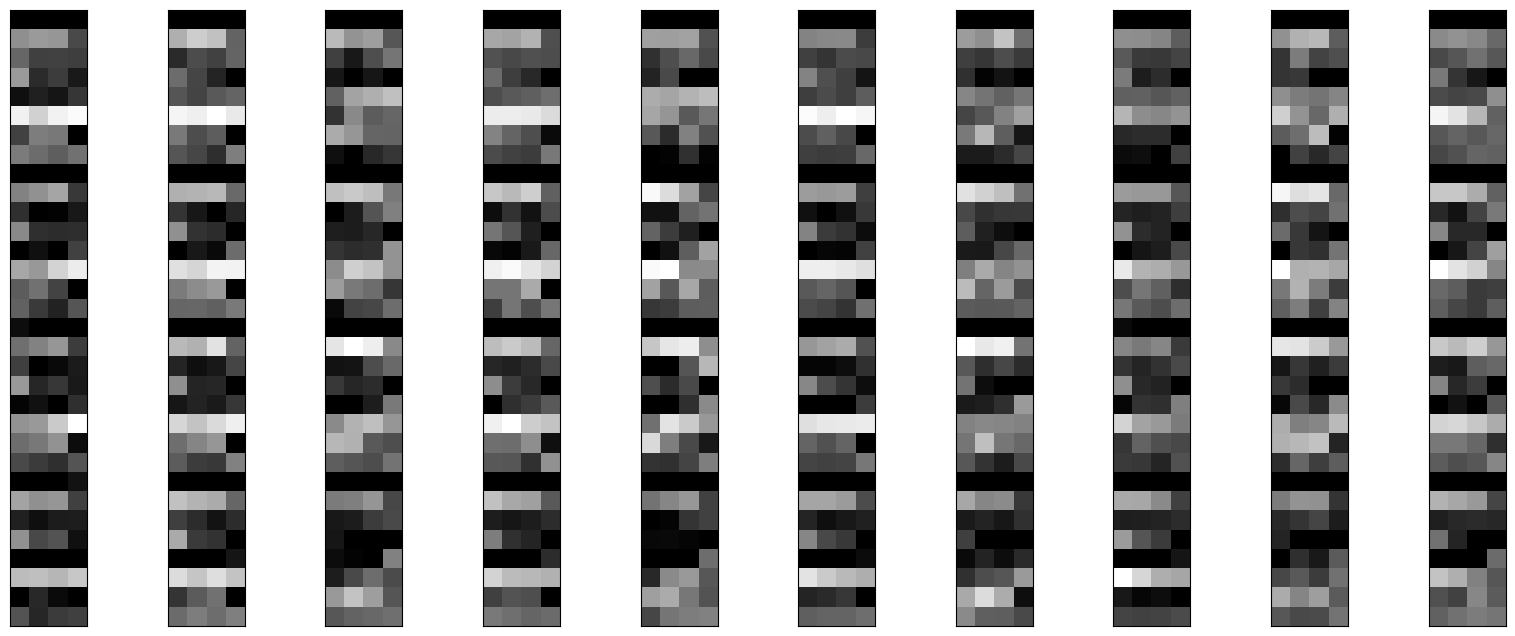

In [30]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# Application to image denoising
* Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy  images to clean  images.

* Here's how we will generate synthetic noisy images: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [31]:


def preprocess_images(image_path, target_size=(28, 28), noise_factor=0.5):
    images = []
    noisy_images = []
    labels = []
    
    class_folders = os.listdir(image_path)
    
    for class_name in tqdm(class_folders, desc="Processing images", unit="folder"):
        class_folder = os.path.join(image_path, class_name)
        
        if os.path.isdir(class_folder):
            filenames = os.listdir(class_folder)
            
            for filename in filenames:
                img_path = os.path.join(class_folder, filename)
                
                if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale image
                
                if img is None:
                    print(f"Failed to load image: {img_path}")
                    continue
                
                img = cv2.resize(img, target_size)  # Resize image to 28x28
                img = img.astype("float32") / 255.0  # Normalize the image
                
                img = np.expand_dims(img, axis=-1)  # Reshape to (28, 28, 1)

                # Add Gaussian noise
                noisy_img = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
                noisy_img = np.clip(noisy_img, 0., 1.)  # Ensure values remain in [0, 1]

                images.append(img)  # Original image
                noisy_images.append(noisy_img)  # Noisy image
                labels.append(class_name)

    return np.array(images), np.array(noisy_images), np.array(labels)

# Preprocess the training and testing data
X_train, X_train_noisy, y_train = preprocess_images(train_image_path)
X_test, X_test_noisy, y_test = preprocess_images(test_image_path)

# Print shapes of the train and test datasets to confirm
print(f"X_train Shape: {X_train.shape}")  
print(f"X_train_noisy Shape: {X_train_noisy.shape}")  
print(f"X_test Shape: {X_test.shape}")  
print(f"X_test_noisy Shape: {X_test_noisy.shape}")  


Processing images:  10%|█         | 1/10 [00:00<00:02,  3.38folder/s]

Failed to load image: /kaggle/input/fruit-classification10-class/MY_data/train/orange/img_2731.jpeg


Processing images: 100%|██████████| 10/10 [00:01<00:00,  6.87folder/s]

X_train Shape: (2300, 28, 28, 1)
X_train_noisy Shape: (2300, 28, 28, 1)
X_test Shape: (1025, 28, 28, 1)
X_test_noisy Shape: (1025, 28, 28, 1)


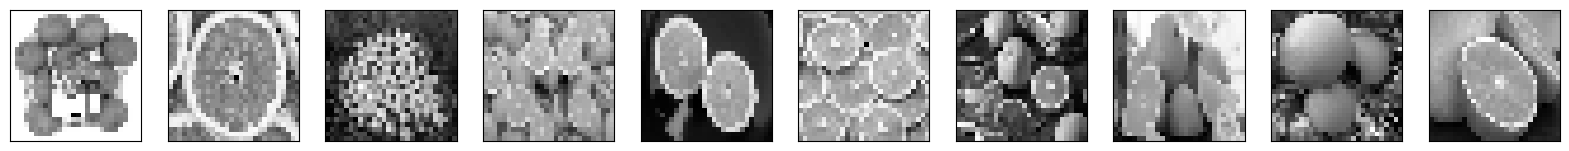

In [32]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

## Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [33]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history=autoencoder.fit(X_train_noisy,X_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test_noisy,X_test))

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 0.6741 - val_loss: 0.5907
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5862 - val_loss: 0.5592
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5721 - val_loss: 0.5451
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5578 - val_loss: 0.5442
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5570 - val_loss: 0.5387
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5564 - val_loss: 0.5376
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5558 - val_loss: 0.5366
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5496 - val_loss: 0.5363
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5575 - val_loss: 0.5361
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5473 - val_loss: 0.5360
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5488 - val_loss: 0.5360
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0

# Now let's take a look at the results. Top, the noisy digits fed to the network, and bottom, the Images are reconstructed by the network.

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step 


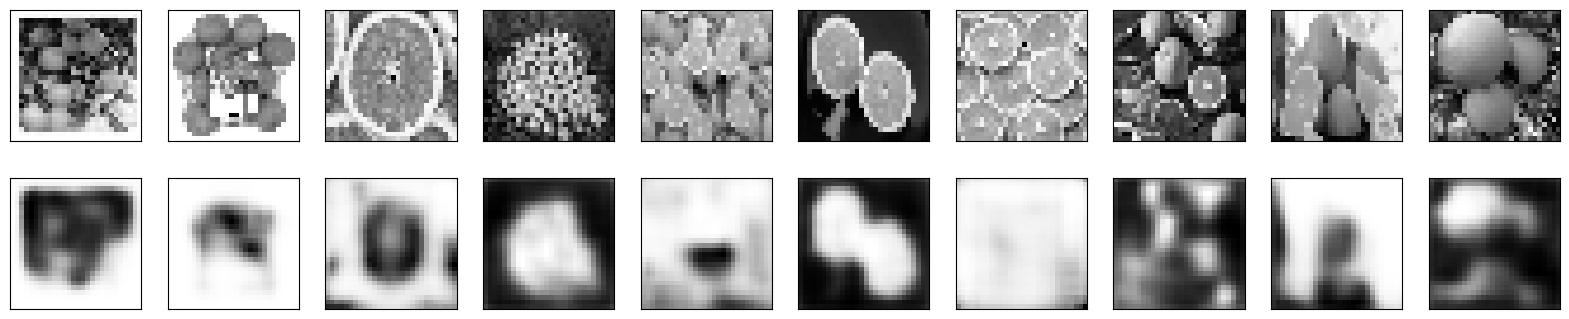

In [35]:
decoded_imgs = autoencoder.predict(X_test)
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Sequence-to-sequence autoencoder
* If you inputs are sequences, rather than vectors or 2D images, then you may want to use as encoder and decoder a type of model that can capture temporal structure, such as a LSTM. To build a LSTM-based autoencoder, first use a LSTM encoder to turn your input sequences into a single vector that contains information about the entire sequence, then repeat this vector n times (where n is the number of timesteps in the output sequence), and run a LSTM decoder to turn this constant sequence into the target sequence.

* We won't be demonstrating that one on any specific dataset. We will just put a code example here for future reference for the reader!

# Variational autoencoder (VAE)
* Variational autoencoders are a slightly more modern and interesting take on autoencoding.

* What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

# How does a variational autoencoder work?

* First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

* The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

* Because a VAE is a more complex example, we have made the code available on Github as a standalone script. Here we will review step by step how the model is created.

* First, here's our encoder network, mapping inputs to our latent distribution parameters:

In [36]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras import backend as K

# Preprocessing function
def preprocess_images(image_path, target_size=(28, 28)):
    images = []
    labels = []
    class_folders = os.listdir(image_path)
    for class_name in tqdm(class_folders, desc="Processing images", unit="folder"):
        class_folder = os.path.join(image_path, class_name)
        if os.path.isdir(class_folder):
            filenames = os.listdir(class_folder)
            for filename in filenames:
                img_path = os.path.join(class_folder, filename)
                if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Failed to load image: {img_path}")
                    continue
                img = cv2.resize(img, target_size)
                img = img.astype("float32") / 255.0
                img = img.flatten()
                images.append(img)
                labels.append(class_name)
    return np.array(images), np.array(labels)


# Preprocess data
X_train, y_train = preprocess_images(train_image_path)
X_test, y_test = preprocess_images(test_image_path)
print(f"Train Data Shape: {X_train.shape}")
print(f"Test Data Shape: {X_test.shape}")

# Define VAE parameters
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

# Encoder
inputs = Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

# Custom VAE class
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')

    def call(self, inputs, training=None):
        z_mean, z_log_sigma, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data
            
        with tf.GradientTape() as tape:
            z_mean, z_log_sigma, z = self.encoder(x)
            reconstructed = self.decoder(z)
            
            # Fix for dimensionality issue
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.reshape(x, [-1, original_dim]),tf.reshape(reconstructed, [-1, original_dim])))
            
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1))
            
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {"loss": self.total_loss_tracker.result(),"reconstruction_loss": self.reconstruction_loss_tracker.result(),"kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data
            
        z_mean, z_log_sigma, z = self.encoder(x)
        reconstructed = self.decoder(z)
        
        # Use the same loss calculation as in train_step
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.reshape(x, [-1, original_dim]),tf.reshape(reconstructed, [-1, original_dim])))
        
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1))
        
        total_loss = reconstruction_loss + kl_loss
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {"loss": self.total_loss_tracker.result(),"reconstruction_loss": self.reconstruction_loss_tracker.result(),"kl_loss": self.kl_loss_tracker.result()}

    @property
    def metrics(self):
        return [self.total_loss_tracker,self.reconstruction_loss_tracker,self.kl_loss_tracker]

# Instantiate and compile VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

# Build and summarize
vae.build((None, original_dim))
vae.summary()



Processing images:  10%|█         | 1/10 [00:00<00:02,  3.42folder/s]

Failed to load image: /kaggle/input/fruit-classification10-class/MY_data/train/orange/img_2731.jpeg


Processing images: 100%|██████████| 10/10 [00:01<00:00,  7.17folder/s]

Train Data Shape: (2300, 784)
Test Data Shape: (1025, 784)


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ [(None, 2), (None, 2),      │          50,500 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 784)                 │          51,152 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,652 (397.08 KB)

 Trainable params: 101,652 (397.08 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Train the model
history = vae.fit(X_train,epochs=100,batch_size=32,validation_data=(X_test))  


Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - kl_loss: 0.0921 - loss: 0.7832 - reconstruction_loss: 0.6911 - val_kl_loss: 0.0112 - val_loss: 0.6891 - val_reconstruction_loss: 0.6780
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0063 - loss: 0.6844 - reconstruction_loss: 0.6781 - val_kl_loss: 3.8150e-04 - val_loss: 0.6737 - val_reconstruction_loss: 0.6734
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 2.1393e-04 - loss: 0.6779 - reconstruction_loss: 0.6777 - val_kl_loss: 2.2202e-04 - val_loss: 0.6734 - val_reconstruction_loss: 0.6731
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.0620e-04 - loss: 0.6780 - reconstruction_loss: 0.6779 - val_kl_loss: 1.8148e-04 - val_loss: 0.6727 - val_reconstruction_loss: 0.6725
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 9.0689e-05 - loss: 0.6775 - reconstruction_loss: 0.6774 - val_kl_loss: 1.8701e-04 - val_loss: 0.6726 - val_reconstruction_loss: 0.6724
Epoch 6/100
72/72 ━━━━━━━━

dict_keys(['kl_loss', 'loss', 'reconstruction_loss', 'val_kl_loss', 'val_loss', 'val_reconstruction_loss'])


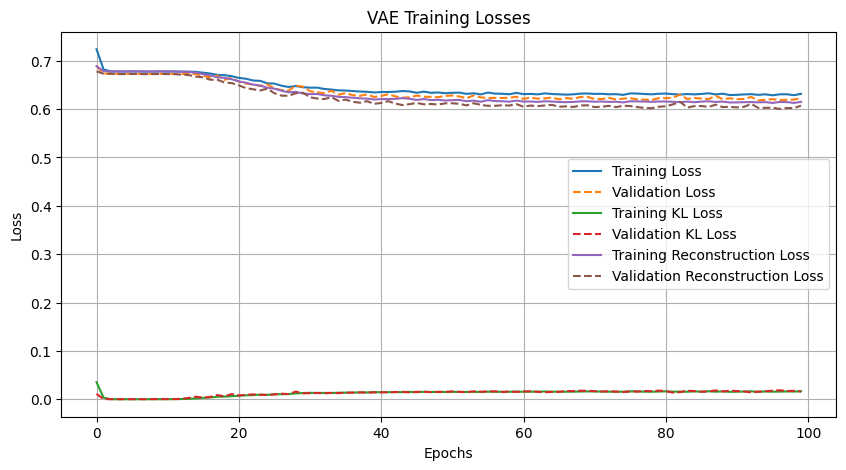

In [38]:
import matplotlib.pyplot as plt

# Extract history dictionary
history_dict = history.history  # Access training history

# Check available keys
print(history_dict.keys())

plt.figure(figsize=(10, 5))

# Total loss
plt.plot(history_dict.get('loss', []), label='Training Loss')
plt.plot(history_dict.get('val_loss', []), label='Validation Loss', linestyle='dashed')

# KL Divergence loss
plt.plot(history_dict.get('kl_loss', []), label='Training KL Loss')
plt.plot(history_dict.get('val_kl_loss', []), label='Validation KL Loss', linestyle='dashed')

# Reconstruction loss
plt.plot(history_dict.get('reconstruction_loss', []), label='Training Reconstruction Loss')
plt.plot(history_dict.get('val_reconstruction_loss', []), label='Validation Reconstruction Loss', linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VAE Training Losses')
plt.legend()
plt.grid()
plt.show()


In [39]:
print(history.history.keys())


dict_keys(['kl_loss', 'loss', 'reconstruction_loss', 'val_kl_loss', 'val_loss', 'val_reconstruction_loss'])


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


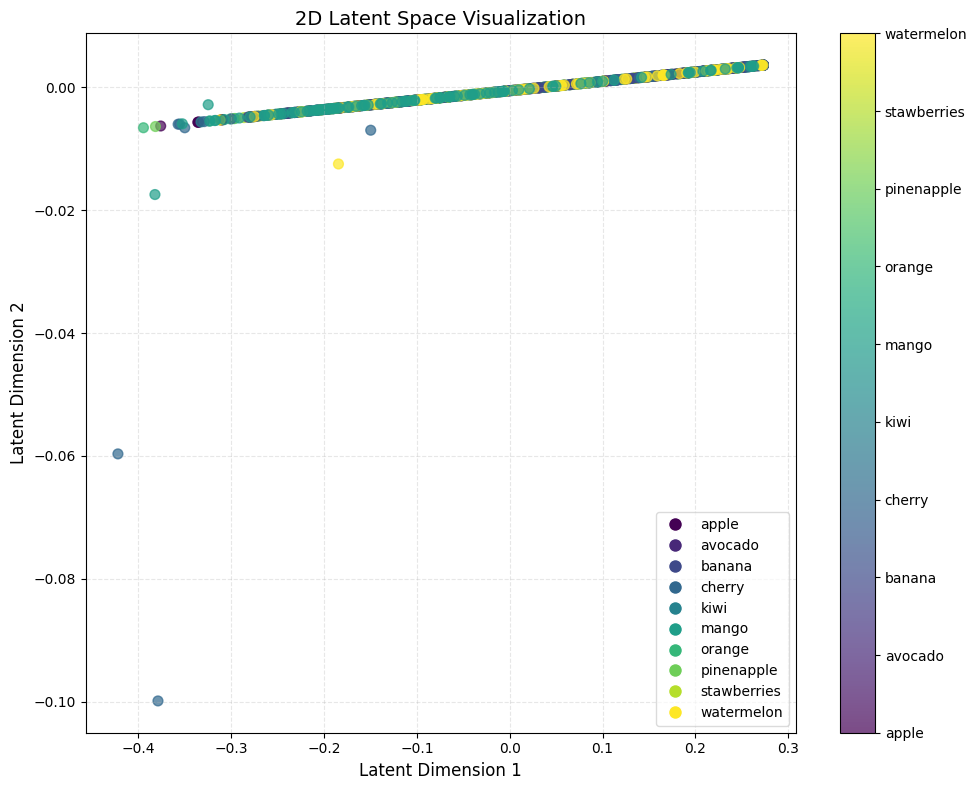

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Set batch size
batch_size = 64

outputs = encoder.predict(X_test, batch_size=batch_size)
z_mean = outputs[0]  # Get the first element (z_mean)

# Use z_mean for visualization
x_test_encoded = z_mean

# Convert string labels to numeric values for coloring
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(y_test)

# Create a figure
plt.figure(figsize=(10, 8))

# Create a scatter plot with numeric labels for coloring
scatter = plt.scatter(x_test_encoded[:, 0],x_test_encoded[:, 1],c=numeric_labels,cmap='viridis',alpha=0.7,s=50)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(label_encoder.classes_)))
cbar.set_ticklabels(label_encoder.classes_)

# Add labels and title
plt.xlabel('Latent Dimension 1', fontsize=12)
plt.ylabel('Latent Dimension 2', fontsize=12)
plt.title('2D Latent Space Visualization', fontsize=14)

# Create a proper legend
handles = []
labels = []
for i, class_name in enumerate(label_encoder.classes_):
    # Get a color from the colormap for this class
    color = plt.cm.viridis(i / (len(label_encoder.classes_) - 1))
    # Create a handle (a Line2D object) for the legend with this color
    handle = plt.Line2D([0], [0],marker='o',color='w',markerfacecolor=color, markersize=10,label=class_name)
    handles.append(handle)
    labels.append(class_name)

# Add the legend
plt.legend(handles=handles, labels=labels, loc='best', frameon=True, framealpha=0.7)

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 


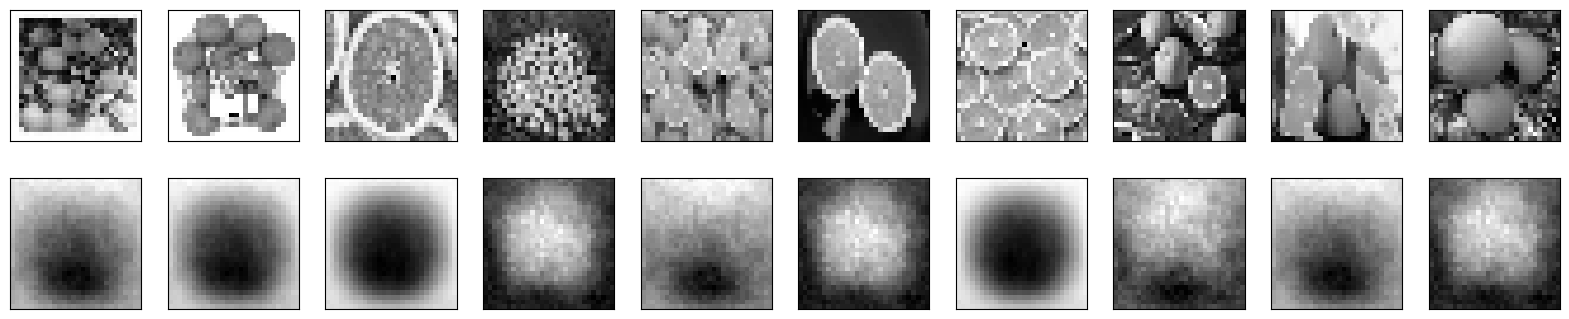

In [41]:
decoded_imgs = vae.predict(X_test)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

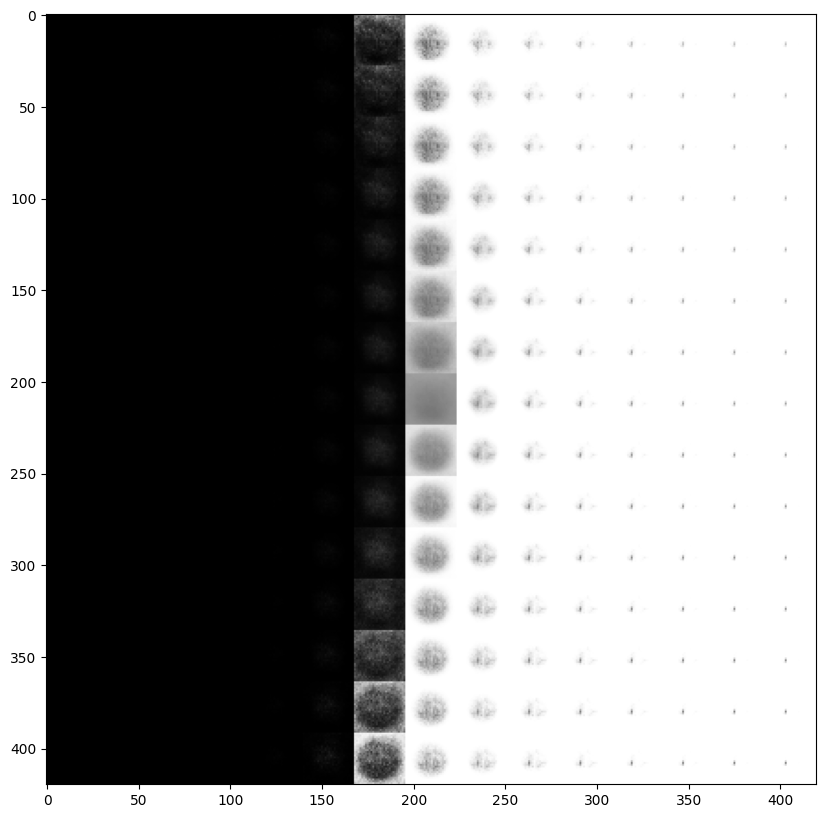

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()